In [ ]:
import numpy as np

import timeit

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Загрузка датасета

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#копирование cancer_detection.zip в content
!cp /content/drive/MyDrive/Colab_Notebooks/diploma/dataset/cancer_detection.zip /content/

In [ ]:
#проверка, что cancer_detection.zip находится в content
!ls /content/

cancer_detection.zip  drive  sample_data


In [ ]:
!unzip -qq "/content/cancer_detection.zip"

### Без аугментации

In [ ]:
image_transforms = transforms.Compose([
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

In [ ]:
train_data = datasets.ImageFolder('./cancer_detection/train', transform=image_transforms)
test_data = datasets.ImageFolder('./cancer_detection/test', transform=image_transforms)

# делим тренировочную часть на train и val

# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

### С аугментацией

In [ ]:
# Преобразования для тренировочных данных
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),  # вращение на случайный угол в диапазоне (-30, 30)
    #transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
])

# Преобразования для тестовых и валидационных данных
test_val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
])

# Загрузка данных
all_train_data = datasets.ImageFolder('./cancer_detection/train', transform=train_transforms)
test_data = datasets.ImageFolder('./cancer_detection/test', transform=test_val_transforms)

# Разделение тренировочного набора данных на тренировочный и валидационный поднаборы
train_size = int(len(all_train_data) * 0.8)
val_size = len(all_train_data) - train_size
train_data, all_val_data = torch.utils.data.random_split(all_train_data, [train_size, val_size])

# Создание валидационного набора данных с преобразованиями для тестовых и валидационных данных
val_data = copy.deepcopy(all_val_data)
val_data.dataset.transform = test_val_transforms


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

### Посмотрим на несколько картинок из датасета:

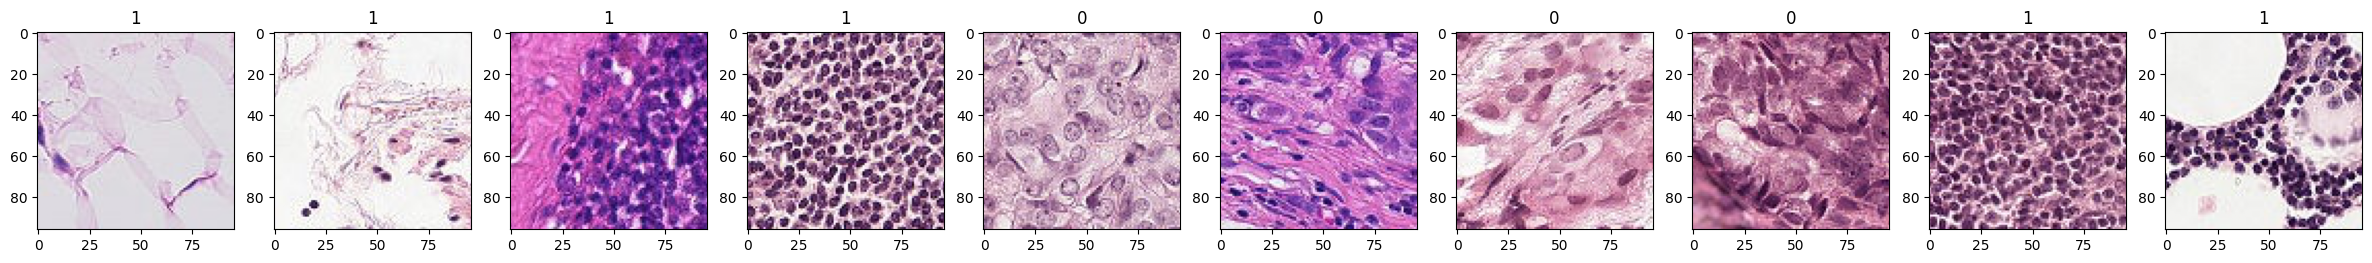

In [ ]:
# функция отрисовки картинок
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    
    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы) 
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

# получаем батч картинок
for batch in train_loader:
    images, labels = batch
    break

show_images(images, labels)

### Построение модели

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 96*96
        # определите слои сети

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3)) #94*94
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3))  #92*92
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) #46*46
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3))  #44*44
        self.conv4 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3))  #42*42
        self.conv5 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3))  #40*40
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2)) #20*20
        self.conv6 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3))  #18*18
        self.conv7 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3))  #16*16


        
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(16 * 16 * 3, 100)
        self.fc2 = nn.Linear(100, 1)

    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(x)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))

        return x

In [ ]:
model = ConvNet()

:Ячейка ниже проверяет, доступен ли GPU и если да, то переносит нейросеть на GPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Обучение модели

Функция обучения сети (ее менять не нужно).

Функция выводит текущие значения лосса и accuracy на train выборке каждые 50 итераций обучения. Также после каждой эпохи считается и выводится лосс и accuracy на val выборке. По этим значениям можно понимать, как хорошо обучается ваша модель.

In [ ]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):
        
        # так получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)
        
        # добавляем дополнительное измерение к целевым меткам
        y_batch = y_batch.unsqueeze(1).float().to(device)

        # print("Размерность y_batch:", y_batch.shape)

        with torch.no_grad():
            logits = model(X_batch.to(device))
            
            #print("Размерность logits:", logits.shape)

            loss = loss_fn(logits, y_batch)
            # loss = loss_fn(logits, y_batch.unsqueeze(1).float().to(device))  # Изменено на добавление размерности
            # loss = loss_fn(logits, y_batch.float().to(device))
            
          
            losses.append(loss.item())
            
            y_pred = torch.round(logits)  # Изменено на бинарные предсказания
            
            num_correct += torch.sum(y_pred.cpu() == y_batch.cpu())
            
    
    # accuracy = num_correct / num_elements
    # accuracy = (num_correct / num_elements).cpu().numpy()  # добавьте .cpu() перед .numpy()
    accuracy = (num_correct / num_elements).item()  # Изменено на .item()

    return accuracy, np.mean(losses)

def train(model, loss_fn, optimizer, n_epoch):
    val_losses = []
    val_accuracies = []
    train_losses = []
    train_accuracies = []
    

    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch+1)

        model.train(True)
        
        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch 
            
            # добавляем дополнительное измерение к целевым меткам
            y_batch = y_batch.unsqueeze(1).float().to(device)

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device)) 

            # print("Размерность logits:", logits.shape)
            
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch) 
            running_losses.append(loss.item())
            
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса
            
            # вычислим accuracy на текущем train батче
            model_answers = torch.round(logits)  # изменено на бинарное предсказание
            train_accuracy = (torch.sum(y_batch == model_answers) / len(y_batch)).item()
            running_accuracies.append(train_accuracy)

        # вычисляем средние значения потерь и точности для этой эпохи и добавляем их в соответствующие списки
        train_loss = sum(running_losses) / len(running_losses)
        train_losses.append(train_loss)

        train_accuracy = sum(running_accuracies) / len(running_accuracies)
        train_accuracies.append(train_accuracy)


        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print("Эпоха {}/{}:\ntrain лосс и accuracy: {}, {}\nval лосс и accuracy: {}, {}".format(
                epoch+1, n_epoch, train_loss, train_accuracy, val_loss, val_accuracy), end='\n')
 
    return model, train_losses, train_accuracies, val_losses, val_accuracies

### Запускаем обучение. Рисуем графики

In [ ]:
# снова объявим модель
model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.BCELoss()

# выбираем алгоритм оптимизации и learning_rate. 
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 1
Эпоха 1/3:
train лосс и accuracy: 0.6756101927294466, 0.5946019629225736
val лосс и accuracy: 0.6750526407430338, 0.5958868265151978
Epoch: 2
Эпоха 2/3:
train лосс и accuracy: 0.6754895610317062, 0.5947280534394478
val лосс и accuracy: 0.6747214756906033, 0.5958868265151978
Epoch: 3
Эпоха 3/3:
train лосс и accuracy: 0.675388885255035, 0.5947655397993744
val лосс и accuracy: 0.6746594415501107, 0.5958868265151978
Обучение длилось: 0 часов, 20 минут, 14.23 секунд


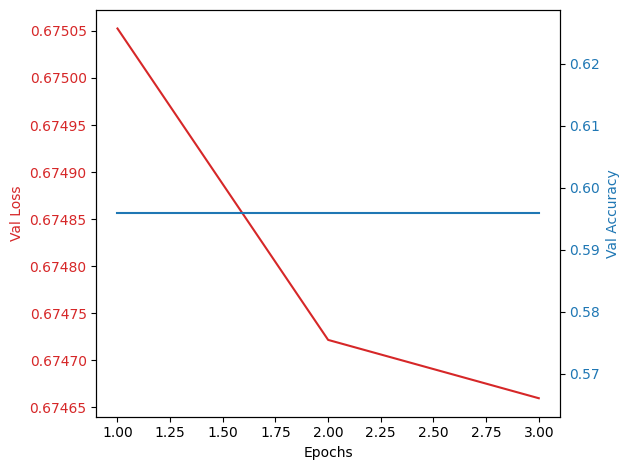

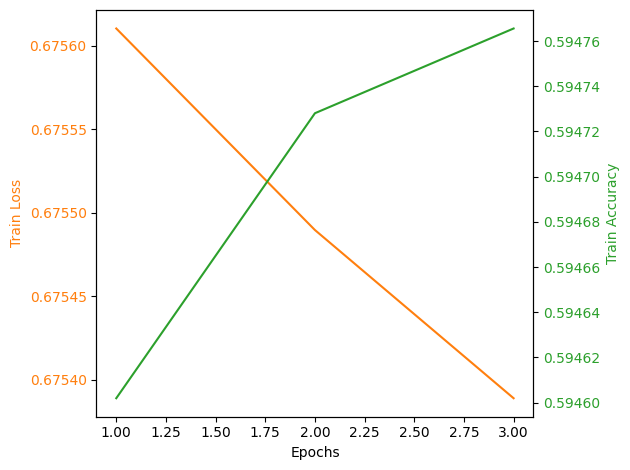

In [ ]:
# запустим обучение модели
# параметр n_epoch можно варьировать

start = timeit.default_timer()

model, train_losses, train_accuracies, val_losses, val_accuracies = train(model, loss_fn, optimizer, n_epoch=3)

end = timeit.default_timer()
execution_time = end - start

# Преобразуем время в часы, минуты и секунды
hours, rem = divmod(execution_time, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Обучение длилось: {int(hours)} часов, {int(minutes)} минут, {seconds:.2f} секунд")

# построение графиков

n_epoch = 3
epochs = range(1, n_epoch + 1)

# Создаем фигуры и оси для первого графика (val_losses, val_accuracies)
fig1, ax1 = plt.subplots()

# График для ошибок
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Val Loss', color=color)
ax1.plot(epochs, val_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Создаем вторые оси, которые разделяют ту же ось x
ax2 = ax1.twinx()

# График для accuracy
color = 'tab:blue'
ax2.set_ylabel('Val Accuracy', color=color) 
ax2.plot(epochs, val_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Отображаем первый график
fig1.tight_layout()
plt.savefig('/content/final_plot_val.png')


# Создаем фигуры и оси для второго графика (train_losses, train_accuracies)
fig2, ax3 = plt.subplots()

# График для ошибок
color = 'tab:orange'
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Train Loss', color=color)
ax3.plot(epochs, train_losses, color=color)
ax3.tick_params(axis='y', labelcolor=color)

# Создаем вторые оси, которые разделяют ту же ось x
ax4 = ax3.twinx()

# График для accuracy
color = 'tab:green'
ax4.set_ylabel('Train Accuracy', color=color) 
ax4.plot(epochs, train_accuracies, color=color)
ax4.tick_params(axis='y', labelcolor=color)

# Отображаем второй график
fig2.tight_layout()
plt.savefig('/content/final_plot_train.png')

# Показываем оба графика
plt.show()


###Протестируем модель

In [ ]:
def get_answer(model, dataloader):
    
    answers_arr = []
  
    images_pathes = [x[0] for x in dataloader.sampler.data_source.imgs]

    for i, batch in enumerate(dataloader):
        
        # получаем текущий батч
        X_batch, y_batch = batch
        
      
        
        # эта строка запрещает вычисление градиентов
        with torch.no_grad():
            # получаем ответы сети на картинки батча
            logits = model(X_batch.to(device))
            
            
            # вычисляем ответы сети
            y_pred = torch.sigmoid(logits) # применяем сигмоиду и округляем
            
            answers_arr.extend(y_pred.data.cpu().numpy())

            
            
    return answers_arr, images_pathes

In [ ]:
answers_arr, images_pathes = get_answer(model, test_loader)

#### Создание csv файла для отправки в kaggle

Проверка, преобразование к нежному виду и проверка массива с идентификаторами





In [ ]:
images_pathes

['./cancer_detection/test/undefined/00006537328c33e284c973d7b39d340809f7271b.tif',
 './cancer_detection/test/undefined/0000ec92553fda4ce39889f9226ace43cae3364e.tif',
 './cancer_detection/test/undefined/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif',
 './cancer_detection/test/undefined/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif',
 './cancer_detection/test/undefined/000270442cc15af719583a8172c87cd2bd9c7746.tif',
 './cancer_detection/test/undefined/000309e669fa3b18fb0ed6a253a2850cce751a95.tif',
 './cancer_detection/test/undefined/000360e0d8358db520b5c7564ac70c5706a0beb0.tif',
 './cancer_detection/test/undefined/00040095a4a671280aeb66cb0c9231e6216633b5.tif',
 './cancer_detection/test/undefined/000698b7df308d75ec9559ef473a588c513a68aa.tif',
 './cancer_detection/test/undefined/0006e1af5670323331d09880924381d67d79eda0.tif',
 './cancer_detection/test/undefined/000997a6038fa7441aa0111ac456255060a354c4.tif',
 './cancer_detection/test/undefined/000c8db3e09f1c0f3652117cf84d78aae100e5a7.tif',
 './

In [ ]:
images_names = [path.split('/')[-1].replace('.tif', '') for path in images_pathes]
images_names

['00006537328c33e284c973d7b39d340809f7271b',
 '0000ec92553fda4ce39889f9226ace43cae3364e',
 '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2',
 '000253dfaa0be9d0d100283b22284ab2f6b643f6',
 '000270442cc15af719583a8172c87cd2bd9c7746',
 '000309e669fa3b18fb0ed6a253a2850cce751a95',
 '000360e0d8358db520b5c7564ac70c5706a0beb0',
 '00040095a4a671280aeb66cb0c9231e6216633b5',
 '000698b7df308d75ec9559ef473a588c513a68aa',
 '0006e1af5670323331d09880924381d67d79eda0',
 '000997a6038fa7441aa0111ac456255060a354c4',
 '000c8db3e09f1c0f3652117cf84d78aae100e5a7',
 '000de14191f3bab4d2d6a7384ca0e5aa5dc0dffe',
 '000e6341cf18365d35b40f4991002fec8834afc0',
 '0010e2887e0b977fcdfdf4c50564fafbbc2b6208',
 '0010e7eaa3d8e14203cd3900b739d8bf0f0b67f0',
 '001161a2eca200f565f12870048a78fa5b320dee',
 '0011807dd1e3306ff3f7a755fd3efbefa2901dce',
 '00118bec91b7fae175791896f7011ff506b3d7dd',
 '0011f0596a038fc8daec4fde71465e347515392e',
 '0014fdb3da986174f9a1d7ae95f3b75a2d025a57',
 '00153be8e27526f9c2f035aff25ca9264db0a2ed',
 '0016dddb

Проверка, преобразование и проверка массива с ответами

In [ ]:
answers_arr

[array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], dtype=float32),
 array([0.644248], d

In [ ]:
answers = [float(arr[0]) for arr in answers_arr]

answers

[0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087280273,
 0.6442480087

In [ ]:
import csv

# Проверка, что количество элементов в обоих массивах одинаково
if len(answers) != len(images_names):
    print("Количество элементов в массивах не совпадает.")
    exit()

# Создание CSV файла и запись данных
with open("convnet_output.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["id", "label"])  # Записываем заголовки столбцов
    for i in range(len(answers)):
        writer.writerow([images_names[i], answers[i]])  # Записываем данные

print("CSV файл успешно создан.")


CSV файл успешно создан.


In [ ]:
import pandas as pd

# Указываете путь к файлу CSV
csv_path = "convnet_output.csv"

# Чтение CSV файла и загрузка данных в DataFrame
data = pd.read_csv(csv_path)

# Выполнение операции вычитания 1 из столбца "label"
data["label"] = 1 - data["label"]

# Сохранение измененных данных обратно в CSV файл
data.to_csv(csv_path, index=False)

print("Столбец 'label' успешно изменен в файле convnet_output.csv.")


Столбец 'label' успешно изменен в файле convnet_output.csv.
